In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

In [ ]:
df1 = pd.read_csv("NIFTY 50_Historical_TR_01011996to18042025.csv", index_col= 'Date', parse_dates=True)
df2 = pd.read_csv("NIFTY 50_Historical_PE_PB_DIV_Data_01011996to18042025.csv", index_col= 'Date', parse_dates=True)
df3 = pd.read_csv("India VIX Historical Data.csv", index_col= 'Date', parse_dates=True)['Price'].to_frame()
df3.columns = ['VIX_price']


df1.sort_index(inplace=True)
df2.sort_index(inplace=True)
df3.sort_index(inplace=True)

df = pd.concat([df1,df3], axis=1)
df = df.dropna()
df.drop(columns=['IndexName'], inplace=True)

for i in df.columns:
    df[i] = df[i].pct_change()
    
for i in df.columns:
    for j in range(1, 200):
        df[f'{i}_lag{j}'] = df[i].shift(j)
        
df['result'] = df['Total Returns Index'].shift(-1)

df = df.dropna()

In [459]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [460]:
X

,Total Returns Index,VIX_price,Total Returns Index_lag1,Total Returns Index_lag2,Total Returns Index_lag3,Total Returns Index_lag4,Total Returns Index_lag5,Total Returns Index_lag6,Total Returns Index_lag7,Total Returns Index_lag8,Total Returns Index_lag9,Total Returns Index_lag10,Total Returns Index_lag11,Total Returns Index_lag12,Total Returns Index_lag13,Total Returns Index_lag14,Total Returns Index_lag15,Total Returns Index_lag16,Total Returns Index_lag17,Total Returns Index_lag18,Total Returns Index_lag19,Total Returns Index_lag20,Total Returns Index_lag21,Total Returns Index_lag22,Total Returns Index_lag23,Total Returns Index_lag24,Total Returns Index_lag25,Total Returns Index_lag26,Total Returns Index_lag27,Total Returns Index_lag28,Total Returns Index_lag29,Total Returns Index_lag30,Total Returns Index_lag31,Total Returns Index_lag32,Total Returns Index_lag33,Total Returns Index_lag34,Total Returns Index_lag35,Total Returns Index_lag36,Total Returns Index_lag37,Total Returns Index_lag38,Total Returns Index_lag39,Total Returns Index_lag40,Total Returns Index_lag41,Total Returns Index_lag42,Total Returns Index_lag43,Total Returns Index_lag44,Total Returns Index_lag45,Total Returns Index_lag46,Total Returns Index_lag47,Total Returns Index_lag48,Total Returns Index_lag49,Total Returns Index_lag50,Total Returns Index_lag51,Total Returns Index_lag52,Total Returns Index_lag53,Total Returns Index_lag54,Total Returns Index_lag55,Total Returns Index_lag56,Total Returns Index_lag57,Total Returns Index_lag58,...,VIX_price_lag140,VIX_price_lag141,VIX_price_lag142,VIX_price_lag143,VIX_price_lag144,VIX_price_lag145,VIX_price_lag146,VIX_price_lag147,VIX_price_lag148,VIX_price_lag149,VIX_price_lag150,VIX_price_lag151,VIX_price_lag152,VIX_price_lag153,VIX_price_lag154,VIX_price_lag155,VIX_price_lag156,VIX_price_lag157,VIX_price_lag158,VIX_price_lag159,VIX_price_lag160,VIX_price_lag161,VIX_price_lag162,VIX_price_lag163,VIX_price_lag164,VIX_price_lag165,VIX_price_lag166,VIX_price_lag167,VIX_price_lag168,VIX_price_lag169,VIX_price_lag170,VIX_price_lag171,VIX_price_lag172,VIX_price_lag173,VIX_price_lag174,VIX_price_lag175,VIX_price_lag176,VIX_price_lag177,VIX_price_lag178,VIX_price_lag179,VIX_price_lag180,VIX_price_lag181,VIX_price_lag182,VIX_price_lag183,VIX_price_lag184,VIX_price_lag185,VIX_price_lag186,VIX_price_lag187,VIX_price_lag188,VIX_price_lag189,VIX_price_lag190,VIX_price_lag191,VIX_price_lag192,VIX_price_lag193,VIX_price_lag194,VIX_price_lag195,VIX_price_lag196,VIX_price_lag197,VIX_price_lag198,VIX_price_lag199
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-12-31,-0.006834,0.013644,0.019616,0.022737,-0.020444,-0.017450,-0.021606,-0.012426,0.005484,0.036013,-0.028734,0.020313,0.020475,0.000413,-0.002756,0.051816,0.025643,-0.026407,0.049513,-0.000503,-0.009350,-0.026211,0.001031,0.037026,-0.020036,0.005497,0.054962,-0.031078,-0.017932,-0.041589,-0.003829,-0.013388,-0.030685,-0.066581,0.058942,0.027791,-0.034172,-0.046831,0.032284,0.054851,0.069909,0.004814,0.063539,-0.023152,-0.122021,-0.039796,-0.052321,0.035898,0.015757,-0.059628,-0.020476,-0.051235,0.008015,0.064250,-0.066509,-0.025772,0.001177,-0.056562,-0.033528,0.007537,...,0.016767,0.046683,-0.033910,0.105322,-0.049858,-0.139442,0.141308,-0.133899,-0.029974,-0.023810,0.251256,0.114846,0.074839,-0.198828,-0.006845,-0.125935,0.061270,0.144206,0.061295,0.035116,0.006022,-0.006382,0.035523,-0.074541,0.000000,-0.052860,0.008029,-0.046293,-0.112450,-0.182988,0.461993,0.000000,-0.030064,-0.075753,-0.106414,0.108453,-0.201883,0.217834,0.013230,-0.160845,0.006816,0.091017,-0.042165,-0.001138,0.062594,-0.112929,0.002690,0.116517,-0.054246,-0.007890,-0.062104,0.131917,0.074574,-0.089019,0.055315,-0.010095,0.003376,-0.074432,-0.008730,-0.067489
2009-01-01,0.025114,-0.040613,-0.006834,0.019616,0.022737,-0.020444,-0.017450,-0.021606,-0.012426,0.005484,0.036013,-0.028734,0.020313,0.020475,0.000413,-0.002756

In [461]:
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(X)

In [462]:
a = pd.DataFrame(pca.components_, columns=X.columns, index = pca.get_feature_names_out())
abs(a.sum()).sort_values(ascending  =False).head(50)

VIX_price_lag92     3.008730
VIX_price_lag38     2.793153
VIX_price_lag84     2.585683
VIX_price_lag74     2.578618
VIX_price_lag114    2.425002
VIX_price_lag124    2.359421
VIX_price_lag20     2.314733
VIX_price_lag95     2.133294
VIX_price_lag76     2.101986
VIX_price_lag51     1.961728
VIX_price_lag23     1.846183
VIX_price_lag141    1.829174
VIX_price_lag18     1.792784
VIX_price_lag145    1.746162
VIX_price_lag191    1.697950
VIX_price_lag83     1.627473
VIX_price_lag172    1.613556
VIX_price_lag33     1.579024
VIX_price_lag125    1.557937
VIX_price_lag27     1.555656
VIX_price_lag151    1.544283
VIX_price_lag134    1.479195
VIX_price_lag90     1.469610
VIX_price_lag103    1.451761
VIX_price_lag8      1.426060
VIX_price_lag78     1.372856
VIX_price_lag183    1.355192
VIX_price_lag132    1.351508
VIX_price_lag135    1.341299
VIX_price_lag104    1.335570
VIX_price_lag130    1.325558
VIX_price_lag180    1.302689
VIX_price_lag152    1.298033
VIX_price_lag41     1.287570
VIX_price_lag6

In [463]:



#results = []
#for i in range(1000, len(X)):

def backtester(i):
    model = Ridge(alpha=0.5)
    
    scaler = StandardScaler()
    scaler_y = StandardScaler()
    
    
    inde = X.iloc[i-1000:i]
    dep = y.iloc[i-1000:i]
    
    scaled_X = scaler.fit_transform(inde)
    scaled_y = scaler_y.fit_transform(dep.values.reshape(-1,1))
    
    
    model.fit(scaled_X,scaled_y)
    
    prediction = model.predict(scaler.transform(X.iloc[[i]]))

    
    #results.append([X.index[i], scaler_y.inverse_transform(prediction.reshape(-1,1))])
    
    #print(results[-1])
    
    return [X.index[i], scaler_y.inverse_transform(prediction.reshape(-1,1))]
    
    

In [464]:
from joblib import Parallel, delayed

results_parallel =Parallel(n_jobs = -1, verbose=True)(delayed(backtester)(i) for i in range(1000, len(X)))



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3034 out of 3034 | elapsed:  1.4min finished


In [ ]:
results_parallel

In [472]:
data = pd.DataFrame(results)
data.columns = ['Date', "Position"]
data.index = data['Date']
data.drop(columns='Date', inplace=True)
data['Position'] = data['Position'].apply(lambda x: x[0][0])
data = pd.concat([data, X['Total Returns Index']], axis =1)
data = data.dropna()
data['Total Returns Index'] = data['Total Returns Index']+1
data['ret'] = np.where(data['Position'] >0, data['Total Returns Index'].shift(-1),1)
data['strat_nav'] = data['ret'].cumprod()
data['index_nav'] = data['Total Returns Index'].cumprod()

data['strat_dd'] = (data['strat_nav'] - data['strat_nav'].cummax())/data['strat_nav'].cummax()
data['index_dd'] = (data['index_nav'] - data['index_nav'].cummax())/data['index_nav'].cummax()

data

,Position,Total Returns Index,ret,strat_nav,index_nav,strat_dd,index_dd
Date,,,,,,,
2012-03-29,-0.002020,0.996935,1.000000,1.000000,0.996935,0.000000,0.000000
2012-03-30,0.002564,1.022536,1.004221,1.004221,1.019402,0.000000,0.000000
2012-04-02,0.000129,1.004221,1.007635,1.011888,1.023705,0.000000,0.000000
2012-04-03,0.001789,1.007635,0.993352,1.005162,1.031521,-0.006648,0.000000
2012-04-04,0.000385,0.993352,0.983372,0.988448,1.024664,-0.023165,-0.006648
...,...,...,...,...,...,...,...
2025-04-08,0.000599,1.016887,0.993935,3.004940,5.088825,-0.091075,-0.136920
2025-04-09,-0.000214,0.993935,1.000000,3.004940,5.057960,-0.091075,-0.142155
2025-04-11,-0.003057,1.019169,1.000000,3.004940,5.154915,-0.091075,-0.125711


<Axes: xlabel='Date'>

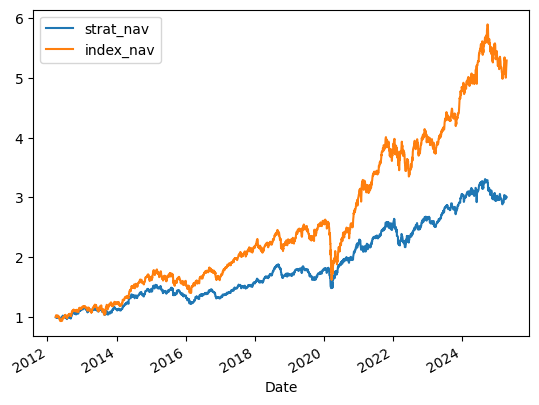

In [473]:
data[['strat_nav', 'index_nav']].plot()

<Axes: xlabel='Date'>

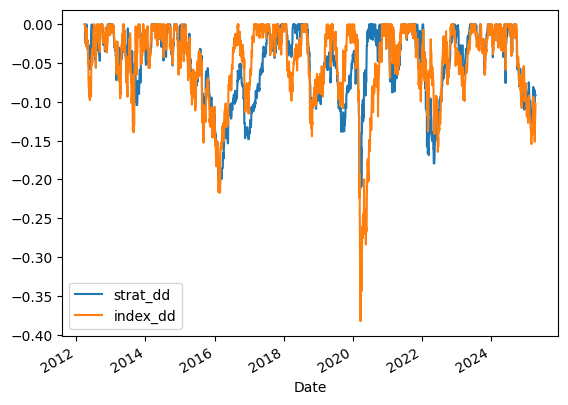

In [474]:
data[['strat_dd', 'index_dd']].plot()

In [82]:
a = df1.resample('M').last()
a['chg'] = a['Total Returns Index'].pct_change()
a = a.dropna()
a

C:\Users\soham jain\AppData\Local\Temp\ipykernel_31352\3772556760.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  a = df1.resample('M').last()


,IndexName,Total Returns Index,chg
Date,,,
1999-07-31,NIFTY 50,1386.99,0.103957
1999-08-31,NIFTY 50,1496.66,0.079071
1999-09-30,NIFTY 50,1497.90,0.000829
1999-10-31,NIFTY 50,1405.03,-0.062000
1999-11-30,NIFTY 50,1459.09,0.038476
...,...,...,...
2024-12-31,NIFTY 50,35155.77,-0.020153
2025-01-31,NIFTY 50,34998.01,-0.004487
2025-02-28,NIFTY 50,32973.36,-0.057850


In [83]:
np.std(a['chg'])*24350

np.float64(1528.0279550597545)

In [72]:
b = a['chg'].values*100

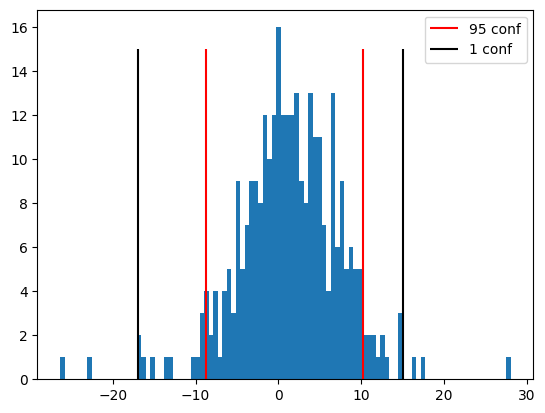

In [70]:
plt.hist(b, bins =100)
plt.vlines(np.percentile(b,5), 0,15, colors = 'red', label='95 conf')
plt.vlines(np.percentile(b,95), 0,15, colors = 'red')
plt.vlines(np.percentile(b,1), 0,15, colors = 'black', label='1 conf')
plt.vlines(np.percentile(b,99), 0,15, colors = 'black')
plt.legend()

In [41]:
np.percentile(b,5)

np.float64(-0.04769264699974779)

In [14]:
df1.index.date[0].strftime('%A')

'Wednesday'